## References

## Business Problem

- Use ResNet34 or ResNet18 Pre-trained model on Imagenet for CIFAR100 dataset. 
- Describe the strategy you'd use to do this. 
- Implement the code
- Get at least 80% VA. https://benchmarks.ai/cifar-100
- Use your library for TFRecords, CutOut, and showing misclassified images. 


## CIFAR100 Data Analyais

https://www.tensorflow.org/datasets/catalog/cifar100

Working with CIFAR-100 is not a common behavior in deep learning community since it is not easy to train a -really- deep learning model. There are 100 different category labels containing 600 images for each (1 testing image for 5 training images per class). The 100 classes in the CIFAR-100 are grouped into 20 super-classes. Each image comes with a “fine” label (the class to which it belongs) and a “coarse” label (the super-class to which it belongs). We will work with the fine labels.

![Image](https://miro.medium.com/max/1099/1*iI_Wzaif4tML9jZkRNKPWA.png)

## Initial Libraries

In [0]:
# Ensure latest TensorFlow is installed.
# !pip install -q tf-nightly-gpu-2.0-preview
!pip install tensorflow-gpu==2.0.0-beta1
# Load the TensorBoard notebook extension.
%load_ext tensorboard

     |████████████████████████████████| 348.9MB 107kB/s 
     |████████████████████████████████| 3.1MB 39.4MB/s 
     |████████████████████████████████| 501kB 45.7MB/s 


In [0]:
import functools
import tensorflow as tf
import tensorflow_datasets as tfds
# from tensorflow.python.keras import backend
from tensorflow.python.keras import layers

In [0]:
import keras
from keras.datasets import cifar10
from keras.datasets import cifar100
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from keras.optimizers import RMSprop, SGD

# from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
# from keras import regularizers
# from keras.models import Sequential
# from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers import GlobalMaxPooling2D
# from keras.layers import Activation, Flatten, Dense, Dropout
# from keras.layers.normalization import BatchNormalization
# from keras.utils import np_utils
# from keras.preprocessing.image import ImageDataGenerator

# from keras.layers.merge import concatenate
# import cropping	
# from keras.layers.convolutional import Cropping2D
import os

Using TensorFlow backend.


In [0]:
# See available datasets
## https://www.tensorflow.org/datasets
print(tfds.list_builders())

['abstract_reasoning', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small', 'bigearthnet', 'binarized_mnist', 'binary_alpha_digits', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_corrupted', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco2014', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'downsampled_imagenet', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'eurosat', 'fashion_mnist', 'flores', 'food101', 'gap', 'glue', 'groove', 'higgs', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imdb_reviews', 'iris', 'kitti', 'kmnist', 'lfw', 'lm1b', 'lsun', 'malaria', 'mnist', 'mnist_corrupted', 'moving_mnist', 'multi_nli', 'multi_nli_mismatch', 'nsynth', 'omniglot', 'o

In [0]:
!pip list | grep tensorflow
tf.__version__


mesh-tensorflow          0.0.5                
tensorflow               1.14.0               
tensorflow-estimator     1.14.0               
tensorflow-gpu           2.0.0b1              
tensorflow-hub           0.6.0                
tensorflow-metadata      0.14.0               
tensorflow-probability   0.7.0                


'2.0.0-beta1'

## Resnet34 Using Transfer Learning

![Resnet](https://miro.medium.com/max/640/1*kBlZtheCjJiA3F1e0IurCw.png)

In [0]:
def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params

def get_conv_params_same(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'same',
    }
    default_conv_params.update(params)
    return default_conv_params

  
def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

In [0]:
def basic_conv_block(filters, stage, block, strides=(1, 1)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        conv_params_same =get_conv_params_same()


        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = tf.keras.layers.Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        # x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.005),strides=strides, name=conv_name + '1', **conv_params_same)(x)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = tf.keras.layers.Activation('relu', name=relu_name + '2')(x)
        x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.005),name=conv_name + '2', **conv_params)(x)

        shortcut = tf.keras.layers.Conv2D(filters, (1, 1), kernel_regularizer=tf.keras.regularizers.l2(0.005),name=sc_name, strides=strides, **conv_params)(shortcut)
        x = tf.keras.layers.Add()([x, shortcut])
        return x

    return layer

In [0]:
def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_shape = (32,32,3),
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    # input_shape = _obtain_input_shape(input_shape,
    #                                   default_size=224,
    #                                   min_size=101,
    #                                   data_format='channels_last',
    #                                   require_flatten=include_top)

    # if input_tensor is None:
    #     img_input = Input(shape=input_shape, name='data')
    # else:
    #     if not K.is_keras_tensor(input_tensor):
    #         img_input = Input(tensor=input_tensor, shape=input_shape)
    #     else:
    #         img_input = input_tensor
    img_input = tf.keras.layers.Input(shape=input_shape) 
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    conv_params_same =get_conv_params_same()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = tf.keras.layers.BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    # x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(x)
    # x = tf.keras.layers.Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = tf.keras.layers.Conv2D(init_filters, (7, 7), kernel_regularizer=tf.keras.regularizers.l2(0.005),strides=(1, 1), name='conv0', **conv_params_same)(x)

    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.BatchNormalization(name='bn0', **bn_params)(x)
    x = tf.keras.layers.Activation('relu', name='relu0')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    # x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    x = tf.keras.layers.MaxPooling2D(padding='valid', name='pooling0')(x)

    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = tf.keras.layers.BatchNormalization(name='bn1', **bn_params)(x)
    x = tf.keras.layers.Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D(name='pool1')(x)
        x = tf.keras.layers.Dense(classes, name='fc1')(x)
        x = tf.keras.layers.Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    # if input_tensor is not None:
    #     inputs = get_source_inputs(input_tensor)
    # else:
    #     inputs = img_input
        
    # Create model.
    model = tf.keras.Model(img_input, x)

    return model

In [0]:
def basic_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        conv_params_same =get_conv_params_same()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = tf.keras.layers.Activation('relu', name=relu_name + '1')(x)
        # x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params_same)(x)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = tf.keras.layers.Activation('relu', name=relu_name + '2')(x)
        x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = tf.keras.layers.Add()([x, input_tensor])
        return x

    return layer

In [0]:
def usual_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = tf.keras.layers.Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = tf.keras.layers.Conv2D(filters, (1, 1), kernel_regularizer=tf.keras.regularizers.l2(0.005),name=conv_name + '1', **conv_params)(x)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = tf.keras.layers.Activation('relu', name=relu_name + '2')(x)
        x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3),kernel_regularizer=tf.keras.regularizers.l2(0.005), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Activation('relu', name=relu_name + '3')(x)
        x = tf.keras.layers.Conv2D(filters*4, (1, 1),kernel_regularizer=tf.keras.regularizers.l2(0.005), name=conv_name + '3', **conv_params)(x)

        shortcut = tf.keras.layers.Conv2D(filters*4, (1, 1), kernel_regularizer=tf.keras.regularizers.l2(0.005),name=sc_name, strides=strides, **conv_params)(shortcut)
        x = tf.keras.layers.Add()([x, shortcut])
        return x

    return layer

In [0]:
def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_shape = (32,32,3),
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    # input_shape = _obtain_input_shape(input_shape,
    #                                   default_size=224,
    #                                   min_size=101,
    #                                   data_format='channels_last',
    #                                   require_flatten=include_top)

    # if input_tensor is None:
    #     img_input = Input(shape=input_shape, name='data')
    # else:
    #     if not K.is_keras_tensor(input_tensor):
    #         img_input = Input(tensor=input_tensor, shape=input_shape)
    #     else:
    #         img_input = input_tensor
    img_input = tf.keras.layers.Input(shape=input_shape) 
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    conv_params_same =get_conv_params_same()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = tf.keras.layers.BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    # x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(x)
    # x = tf.keras.layers.Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = tf.keras.layers.Conv2D(init_filters, (7, 7), kernel_regularizer=tf.keras.regularizers.l2(0.005),strides=(1, 1), name='conv0', **conv_params_same)(x)

    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.BatchNormalization(name='bn0', **bn_params)(x)
    x = tf.keras.layers.Activation('relu', name='relu0')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    # x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    x = tf.keras.layers.MaxPooling2D(padding='valid', name='pooling0')(x)

    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = tf.keras.layers.BatchNormalization(name='bn1', **bn_params)(x)
    x = tf.keras.layers.Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D(name='pool1')(x)
        x = tf.keras.layers.Dense(classes, name='fc1')(x)
        x = tf.keras.layers.Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    # if input_tensor is not None:
    #     inputs = get_source_inputs(input_tensor)
    # else:
    #     inputs = img_input
        
    # Create model.
    model = tf.keras.Model(img_input, x)

    return model

In [0]:
def usual_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = tf.keras.layers.Activation('relu', name=relu_name + '1')(x)
        x = tf.keras.layers.Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = tf.keras.layers.Activation('relu', name=relu_name + '2')(x)
        x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
        x = tf.keras.layers.Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = tf.keras.layers.Activation('relu', name=relu_name + '3')(x)
        x = tf.keras.layers.Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        x = tf.keras.layers.Add()([x, input_tensor])
        return x

    return layer

In [0]:
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name

In [0]:
weights_collection = [
    # ResNet34
    {
        # 'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': True,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000.h5',
        'name': 'resnet34_imagenet_1000.h5',
        'md5': '2ac8277412f65e5d047f255bcbd10383',
    },

    {
        # 'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    },
]

In [0]:
def find_weights(weights_collection, model_name, dataset, include_top):
    # w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    # w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['dataset'] == dataset, weights_collection))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w

In [0]:
from keras.utils.data_utils import get_file

def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, model.name, dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))

In [0]:
def ResNet34(input_shape, weights=None, classes=100, include_top=True):
    model = build_resnet(input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    # model.name = 'resnet34'

    if weights:
        load_model_weights(weights_collection, model, weights, classes=classes, include_top=include_top)
    return model

In [0]:
HEIGHT =32
WIDTH =32
input_shape=(HEIGHT, WIDTH, 3)

In [0]:
def build_finetune_model(input_shape=input_shape, num_classes=100, include_top=False,pooling='max'):

  backbone = ResNet34(input_shape=input_shape, weights='imagenet', 
                      classes=num_classes,include_top=include_top)
  
  for layer in backbone.layers:
    layer.trainable = False
  
  x = backbone.output
  # x = tf.keras.layers.Dropout(0.2)(x)
  if pooling == 'avg':
    x = tf.keras.layers.Conv2D(100, (1, 1))(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
  elif pooling == 'max':
    x = tf.keras.layers.Conv2D(100, (1, 1))(x)
    x = tf.keras.layers.GlobalMaxPooling2D(name='global_max_pool')(x)

  # predictions = tf.keras.layers.Dense(num_classes, name='fc',
  #                           activation='softmax',kernel_initializer="he_normal")(x)
  predictions = tf.keras.layers.Activation('softmax', name='softmax')(x)
  finetune_model = tf.keras.Model(inputs=backbone.input, outputs=predictions)

  print("My model Name:",finetune_model.name)
  return finetune_model

    # x = base_model.output
    # x = Flatten()(x)
    # for fc in fc_layers:
    #     # New FC layer, random init
    #     x = Dense(fc, activation='relu')(x) 
    #     x = Dropout(dropout)(x)

    # predictions = Dense(num_classes, activation='softmax')(x) 

In [0]:
resnet_34_cifar_100 = build_finetune_model()

My model Name: model_11


**Strategy for Transfer Learning**

- Replaced all stride 2 with Stride 1
- Max Pooling size has been changed from 3x3 to 2x2
- Top classification layer has not been added and GAP followed by Dense layer with 100 as no of class with softmax activation has been used.
- All layers from stage4 has been set as Trainable = Yes to tune them along with our classification layer.
- ZeroPadding2D into 2nd layer has been removed


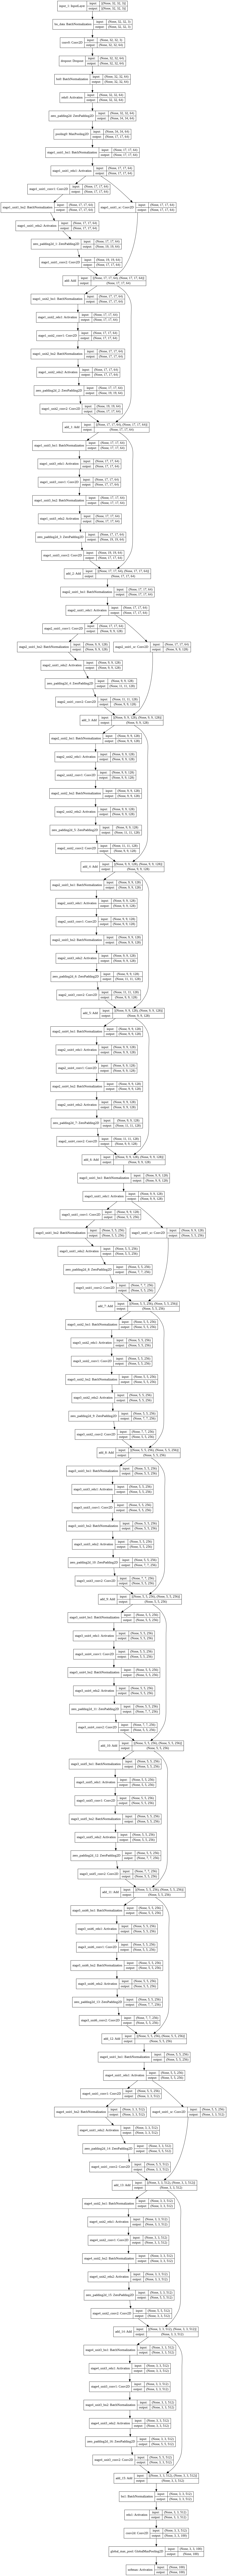

In [0]:
tf.keras.utils.plot_model(resnet_34_cifar_100, to_file='resnet34_cifar100.png', show_layer_names=True, show_shapes=True)

## Importing Own Custom Deeplearning github

In [0]:
!rm -rf deeplearning

In [0]:
!git clone https://github.com/amitkml/deeplearning.git
!ls -ltr
!pwd

Cloning into 'deeplearning'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 117 (delta 37), reused 0 (delta 0), pack-reused 59
Receiving objects: 100% (117/117), 37.31 KiB | 3.73 MiB/s, done.
Resolving deltas: 100% (61/61), done.
total 8
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data
drwxr-xr-x 4 root root 4096 Sep 30 15:41 deeplearning
/content


In [0]:
os.chdir('/content/')
!pwd

from deeplearning.tensorflow import generate_cifar10_tfrecords as tfcifar  ## This is for generating tfrecord in TF 1.14
from deeplearning.tensorflow import read_cifar10_tfrecords as readtfcifar  ## This is for reading tfrecord of cifar10 in TF 1.14
from deeplearning.tensorflow import show_metrices as show_metrices  ## Showing different metrices
from deeplearning.tensorflow import learning_rate_scheduler as learning_rate_scheduler  ## different leaerning rate scheduler

os.chdir('/content/')
!pwd


/content
/content


## Tensorflow Records

### Implementation - cifar10 TFrecord generation through module in github

**High Level Steps for TFRecord Generation**

- Open a TFRecords file using tf.python_io.TFRecordWriter
- Convert your data into the proper data type of the feature using tf.train.Int64List, tf.train.BytesList, or tf.train.FloatList
- Create a feature using tf.train.Feature and pass the converted data to it
- Create an Example protocol buffer using tf.train.Example and pass the feature to it
- Serialize the Example to string using example.SerializeToString()
- Write the serialized example to TFRecords file using writer.write
- Close the file using: writer.close()

In [0]:
## This section has been commented for tensorflow 2.0 compatibility as tensorflow 2.0 has no longer contribute package

# data_dir = '/content/'
# _ = tfcifar.GenerateTFEmain(data_dir)
# !ls -ltr
# currentDT = datetime.datetime.now()
# print("Current time:", currentDT)
(image,label), (val_image, val_label) = keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 4s 0us/step


In [0]:
# label = label.astype('int64').reshape(len_train)
# y_test = y_test.astype('int64').reshape(len_test)
# image=(image/255.0).astype('float32')
# val_image = (val_image/255.0).astype('float32')

# image=image.astype('float32')
# val_image = val_image.astype('float32')


In [0]:
train_mean = np.mean(image, axis=(0,1,2))
train_std = np.std(image, axis=(0,1,2))

In [0]:
print("There are {} train images and {} test images.".format(image.shape[0], val_image.shape[0]))
print('There are {} unique classes to predict.'.format(np.unique(label).shape[0]))

There are 50000 train images and 10000 test images.
There are 100 unique classes to predict.


In [0]:
# Convert 1-dimensional class arrays to 100-dimensional class matrices
from keras.utils import np_utils

label = np_utils.to_categorical(label, 100)
val_label = np_utils.to_categorical(val_label, 100)

In [0]:
## This function will display a specific class from cifar10 dataset  TBD
# show_metrices.show_one_class_images_cifar10(classname ='frog')

In [0]:
## This function will display one image from each class of cufar10 TBD
# show_metrices.display_each_class_one_cifar10()

In [0]:
## Lets draw first 15 images from ciphar10 TVD
# show_metrices.draw_sample(0, 3, 5)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((image,label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image, val_label))

In [0]:
NUM_GPUS = 1
BS_PER_GPU = 128
HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
NUM_CLASSES = 100
NUM_TRAIN_SAMPLES = 50000

In [0]:
def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, HEIGHT + 8, WIDTH + 8)
    x = tf.image.random_crop(x, [HEIGHT, WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    return x, y	

In [0]:
def normalize(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y

In [0]:
 s_l=0.02
 s_h=0.4
 r_1=0.3
 r_2=1/0.3
 v_l=0
 v_h=255
 img_h = 32
 img_w =32

#  s = np.random.uniform(s_l, s_h) # * img_h * img_w
#  s
#  k = tf.random.uniform(shape =[1], minval = s_l, maxval = s_h)
#  k

# left = np.random.randint(0, img_w)
# left

# left = tf.int16(tf.random.uniform(shape =[1],
#                                   minval=0,
#                                   maxval=img_w))

# left

In [0]:
def get_cutout(img,prob=50,size=4,min_size=5,use_fixed_size=False):
  
  
  height = tf.shape(img)[0]
  width = tf.shape(img)[1]
  channel = tf.shape(img)[2]
  
  #subtract the mean of train dataset from the image , we will add this back later 
  mean = tf.constant(train_mean, dtype=tf.float32) # (3)
  mean = tf.reshape(mean, [1, 1, 3])
  img_m = img - mean

  #get cutout size and offsets 
  if (use_fixed_size==True):
    s=size
  else:  
    s=tf.random.uniform([], min_size, size, tf.int32) # use a cutout size between 5 and size 

  x1 = tf.random.uniform([], 0, height+1 - s, tf.int32) # get the x offset from top left
  y1 = tf.random.uniform([], 0, width+1 - s, tf.int32) # get the y offset from top left 

  # create the cutout slice and the mask 
  img1 = tf.ones_like(img)  
  
  cut_slice = tf.slice(
  img1,
  [x1, y1, 0],
  [s, s, 3]
     )
  #create mask similar in shape to input image with cutout area having ones and rest of the area padded with zeros 
  mask = tf.image.pad_to_bounding_box(
    [cut_slice],
    x1,
    y1,
    height,
    width
  )
  
  #invert the zeros and ones 
  mask = tf.ones_like(mask ) - mask
  
  #inv_mask = tf.where( tf.equal( -1.0, mask ), 1.0 * tf.ones_like( mask ), mask ) # not needed
  
  #apply cutout on the image , get back a shape of [1,32,32,3] instead of [32,32,3]
  tmp_img = tf.multiply(img_m,mask)

  #add back the mean that we subtracted 
  cut_img = tmp_img[0] + mean
  
 # commented out initial numpy based implementation 
  '''
  print('cut out using numpy  ')

  ## this worked too , but when applied to tensors , the same cutout region got used for all images ... need to verify again

  mask = np.ones((32, 32,3), np.float32)
  


  
  y = np.random.randint(32)
  x = np.random.randint(32)
  
  length = np.random.randint(1, 17) 

  y1 = np.clip(y - length // 2, 0, 32)
  y2 = np.clip(y + length // 2, 0, 32)
  x1 = np.clip(x - length // 2, 0, 32)
  x2 = np.clip(x + length // 2, 0, 32)
  

  for i in range(3): 
    mask[y1: y2, x1: x2,i] = 0.
  
  tmp_img3=tf.multiply(img,mask) 
  '''
 
    
  return cut_img

In [0]:
def cutout(img,prob=50,size=4,min_size=5,use_fixed_size=False):
  return tf.cond(tf.random.uniform([], 0, 100) > prob, lambda: img , lambda: get_cutout(img,prob,size,min_size,use_fixed_size))

In [0]:
def normalize_augmentation(x, y):
    

    x = tf.image.resize_with_crop_or_pad(
        x, HEIGHT + 4, WIDTH + 4)  ## reduced from 8 to 4
    x = tf.image.random_crop(x, [HEIGHT, WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    # x = tf.image.random_brightness(x,0.1)
    x = tf.image.random_brightness(x,max_delta=63. / 255.)
    x = tf.image.random_contrast(x, 0.8, 1.25)
    # x = tf.image.random_saturation(x, 0.8, 1.25)
    x = tf.image.random_saturation(x, lower = 0.8, upper = 1.25)
    # x = cutout(x,prob=60,size=4,use_fixed_size=True)
    # x = get_random_eraser(x)
    x = tf.image.per_image_standardization(x)
    return x, y	

**Have Implemented Data Pipeline Solution**

* Following best practises have been implemented here to improve the performacne
and it has helped me to reduce per epoch time from 313 sec to 66s.

- Pipelining

    This has helped to achieve from **without pipelining**


![Earlier](https://www.tensorflow.org/images/datasets_without_pipelining.png)

  **with pipelining** 

![Final](https://www.tensorflow.org/images/datasets_with_pipelining.png)

  - Parallelize Data Transformation
    This helps us to use CPU resource effectively. Having more number of parallel call w,r.t CPU may affect the performance. This will help us to have better performane from **Without Parallel Call** to **Parallel Call** as shown in diagram.

    ![Without Parallel Call](https://www.tensorflow.org/images/datasets_parallel_map.png)

  - Performance Considerations
    I have used "Map and Batch" here insted of Map and then calling batch.





In [0]:
tf.random.set_seed(22)
# tf.random.set_random_seed(122)
num_parallel_calls = tf.data.experimental.AUTOTUNE  ## https://www.tensorflow.org/beta/guide/data_performance
buffer_size=tf.data.experimental.AUTOTUNE
shuffle_buffer_size =tf.data.experimental.AUTOTUNE
batch_size = 1000
buffer_size = 1000
# train_dataset = train_dataset.map(normalize_augmentation,
#                                   num_parallel_calls=num_parallel_calls).shuffle(1024).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=False)
# val_dataset = val_dataset.map(normalize,
#                               num_parallel_calls=num_parallel_calls).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=False)

train_dataset = train_dataset.apply(tf.data.experimental.map_and_batch(
    map_func=normalize_augmentation, batch_size=batch_size))

val_dataset = val_dataset.apply(tf.data.experimental.map_and_batch(
    map_func=normalize, batch_size=batch_size))

train_dataset = train_dataset.shuffle(buffer_size=buffer_size)
val_dataset = val_dataset.shuffle(buffer_size=buffer_size)

val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)

# train_dataset = train_dataset.repeat()
# val_dataset = val_dataset.repeat()


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from datetime import datetime
# Load the TensorBoard notebook extension.
%load_ext tensorboard


log_dir="logs/profile/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='epoch',
                                                      histogram_freq=1, 
                                                      profile_batch = 3)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Implementation - cifar100 TFrecord reading through module in github

- Create a list of filenames: In our case we only have a single file data_path = 'train.tfrecords'. Therefore, our list is gonna be like this: [data_path]
- Create a queue to hold filenames: To do so, we use tf.train.string_input_producer tf.train.string_input_producer function which hold filenames in a FIFO queue. it gets the list of filnames. It also has some optional arguments including num_epochs which indicates the number of epoch you want to to load the data and shuffle which indicates whether to suffle the filenames in the list or not. It is set to True by default.
- Define a reader: For files of TFRecords we need to define a TFRecordReader with reader = tf.TFRecordReader(). Now, the reader returns the next record using: reader.read(filename_queue)
- Define a decoder: A decoder is needed to decode the record read by the reader. In case of using TFRecords files the decoder should be tf.parse_single_example. it takes a serialized Example and a dictionary which maps feature keys to FixedLenFeature or VarLenFeature values and returns a dictionary which maps feature keys to Tensor values: features = tf.parse_single_example(serialized_example, features=feature)
- Convert the data from string back to the numbers: tf.decode_raw(bytes, out_type) takes a Tensor of type string and convert it to typeout_type. However, for labels which have not been converted to string, we just need to cast them using tf.cast(x, dtype)
- Reshape data into its original shape: You should reshape the data (image) into it's original shape before serialization using image = tf.reshape(image, [224, 224, 3])
- Preprocessing: if you want to do any preprocessing you should do it now.
- Batching: Another queue is needed to create batches from the examples. We can create the batch queue using tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10) where capacity is the maximum size of queue, min_after_dequeue is the minimum size of queue after dequeue, and num_threads is the number of threads enqueuing examples. Using more than one thread, it comes up with a faster reading. The first argument in a list of tensors which we want to create batches from

## LR Schedule

## Tensorflow Records with Coarse Label

Have referred the paper **Learning Image Representations to Understand and Predict Semantic Hierarchies** for this. Dataset is being taken from [cifar100](https://www.tensorflow.org/datasets/catalog/cifar100) which has already coarse_label and label set.

In [0]:
import tensorflow_datasets as tfds
# See available datasets
print(tfds.list_builders())


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

['abstract_reasoning', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small', 'bigearthnet', 'binarized_mnist', 'binary_alpha_digits', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_corrupted', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco2014', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'downsampled_imagenet', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_m

In [0]:
# Construct a tf.data.Dataset

dataset  = tfds.image.cifar.Cifar100
dataset.as_dataset
# Build your input pipeline
# dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
# for features in dataset.take(1):
#   image, label = features["image"], features["label"]

# dataset= tfds.load(name="Cifar100", split=tfds.Split.TRAIN)

In [0]:
from keras.callbacks import LearningRateScheduler

We base our experiment on the principle of step decay. Here, we reduce the learning rate by a constant factor every few epochs. Typical values might be reducing the learning rate by half every 5 epochs, or by 0.1 every 20 epochs. These numbers depend heavily on the type of problem and the model. One heuristic you may see in practice is to watch the validation error while training with a fixed learning rate, and reduce the learning rate by a constant (e.g. 0.5) whenever the validation error stops improving.

In practice, step decay is preferred as it’s easier to interpret hyperparameters like fraction of decay and the step timings in units of epochs. Also, it’s found to provide stabilization to the value of learning rate which in turn helps the stochastic gradient descent to exhibit fast convergence and a high rate of success.

## Resnet34 Model Finetune

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_34_cifar_100.layers))

Number of layers in the base model:  145


In [0]:
for layer in resnet_34_cifar_100.layers:
  
  # string[0:5]
  print("Layer Name:" ,layer.name, "Trainable:",layer.trainable)
  if (layer.name[0:6] == 'stage4'):
    print("Updated Trainable Flag to Yes for Layer:",layer.name)
    layer.trainable = True
  # if (layer.name[0:6] == 'stage3'):
  #   print("Updated Trainable Flag to Yes for Layer:",layer.name)
  #   layer.trainable = True


Layer Name: input_1 Trainable: False
Layer Name: bn_data Trainable: False
Layer Name: conv0 Trainable: False
Layer Name: dropout Trainable: False
Layer Name: bn0 Trainable: False
Layer Name: relu0 Trainable: False
Layer Name: zero_padding2d Trainable: False
Layer Name: pooling0 Trainable: False
Layer Name: stage1_unit1_bn1 Trainable: False
Layer Name: stage1_unit1_relu1 Trainable: False
Layer Name: stage1_unit1_conv1 Trainable: False
Layer Name: stage1_unit1_bn2 Trainable: False
Layer Name: stage1_unit1_relu2 Trainable: False
Layer Name: zero_padding2d_1 Trainable: False
Layer Name: stage1_unit1_conv2 Trainable: False
Layer Name: stage1_unit1_sc Trainable: False
Layer Name: add Trainable: False
Layer Name: stage1_unit2_bn1 Trainable: False
Layer Name: stage1_unit2_relu1 Trainable: False
Layer Name: stage1_unit2_conv1 Trainable: False
Layer Name: stage1_unit2_bn2 Trainable: False
Layer Name: stage1_unit2_relu2 Trainable: False
Layer Name: zero_padding2d_2 Trainable: False
Layer Name: st

In [0]:
for layer in resnet_34_cifar_100.layers:
  
  # string[0:5]
  print("Layer Name:" ,layer.name, "Trainable:",layer.trainable)
  if (layer.name[0:6] == 'stage4'):
    print("Updated Trainable Flag to Yes for Layer:",layer.name)
    layer.trainable = True
  # if (layer.name[0:6] == 'stage3'):
  #   print("Updated Trainable Flag to Yes for Layer:",layer.name)
  #   layer.trainable = True

Layer Name: input_1 Trainable: False
Layer Name: bn_data Trainable: False
Layer Name: conv0 Trainable: False
Layer Name: dropout Trainable: False
Layer Name: bn0 Trainable: False
Layer Name: relu0 Trainable: False
Layer Name: zero_padding2d Trainable: False
Layer Name: pooling0 Trainable: False
Layer Name: stage1_unit1_bn1 Trainable: False
Layer Name: stage1_unit1_relu1 Trainable: False
Layer Name: stage1_unit1_conv1 Trainable: False
Layer Name: stage1_unit1_bn2 Trainable: False
Layer Name: stage1_unit1_relu2 Trainable: False
Layer Name: zero_padding2d_1 Trainable: False
Layer Name: stage1_unit1_conv2 Trainable: False
Layer Name: stage1_unit1_sc Trainable: False
Layer Name: add Trainable: False
Layer Name: stage1_unit2_bn1 Trainable: False
Layer Name: stage1_unit2_relu1 Trainable: False
Layer Name: stage1_unit2_conv1 Trainable: False
Layer Name: stage1_unit2_bn2 Trainable: False
Layer Name: stage1_unit2_relu2 Trainable: False
Layer Name: zero_padding2d_2 Trainable: False
Layer Name: st

In [0]:
for layer in resnet_34_cifar_100.layers:
  print("Layer Name:" ,layer.name, "Trainable:",layer.trainable)

Layer Name: input_1 Trainable: False
Layer Name: bn_data Trainable: False
Layer Name: conv0 Trainable: False
Layer Name: dropout Trainable: False
Layer Name: bn0 Trainable: False
Layer Name: relu0 Trainable: False
Layer Name: zero_padding2d Trainable: False
Layer Name: pooling0 Trainable: False
Layer Name: stage1_unit1_bn1 Trainable: False
Layer Name: stage1_unit1_relu1 Trainable: False
Layer Name: stage1_unit1_conv1 Trainable: False
Layer Name: stage1_unit1_bn2 Trainable: False
Layer Name: stage1_unit1_relu2 Trainable: False
Layer Name: zero_padding2d_1 Trainable: False
Layer Name: stage1_unit1_conv2 Trainable: False
Layer Name: stage1_unit1_sc Trainable: False
Layer Name: add Trainable: False
Layer Name: stage1_unit2_bn1 Trainable: False
Layer Name: stage1_unit2_relu1 Trainable: False
Layer Name: stage1_unit2_conv1 Trainable: False
Layer Name: stage1_unit2_bn2 Trainable: False
Layer Name: stage1_unit2_relu2 Trainable: False
Layer Name: zero_padding2d_2 Trainable: False
Layer Name: st

In [0]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
resnet_34_cifar_100.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# model_output = cnn_layers(img_input,num_filter=12)
# model = tf.keras.Model(inputs=[img_input], outputs=[model_output])
# train_model = keras.models.Model(inputs=model_input, outputs=model_output)
resnet_34_cifar_100.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           input_1[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 64)   9408        bn_data[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 64)   0           conv0[0][0]                      
____________________________________________________________________________________________

In [0]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_densenet.png')

In [0]:
# from IPython.display import Image
# Image(filename='model_densenet.png')

In [0]:
# from tf.keras.callbacks import LearningRateScheduler
schedule = learning_rate_scheduler.StepDecay(initAlpha=1e-1, factor=0.25, dropEvery=2)
# schedule =learning_rate_scheduler.PolynomialDecay(maxEpochs=2, initAlpha=1e-1, power=5) 
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(schedule)

In [0]:
# !git clone https://github.com/amitkayal/keras-one-cycle.git
# !ls -ltr
# !pwd

# import os

In [0]:
# os.chdir('/content/keras-one-cycle/')
# !pwd

# from clr import LRFinder
# from clr import OneCycleLR

# os.chdir('/content/')
# !pwd

In [0]:
# class CyclicLR(tf.keras.callbacks.Callback):
    
#     def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
#         self.base_lr = base_lr
#         self.max_lr = max_lr
#         self.base_m = base_m
#         self.max_m = max_m
#         self.cyclical_momentum = cyclical_momentum
#         self.step_size = step_size
        
#         self.clr_iterations = 0.
#         self.cm_iterations = 0.
#         self.trn_iterations = 0.
#         self.history = {}
        
#     def clr(self):
        
#         cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
#         if cycle == 2:
#             x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
#             return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
#         else:
#             x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
#             return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
#     def cm(self):
        
#         cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
#         if cycle == 2:
            
#             x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
#             return self.max_m
        
#         else:
#             x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
#             return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
#     def on_train_begin(self, logs={}):
#         logs = logs or {}

#         if self.clr_iterations == 0:
#             tf.keras.backend.replace(self.model.optimizer.lr, self.base_lr)
#         else:
#             tf.keras.backend.replace(self.model.optimizer.lr, self.clr())
            
#         if self.cyclical_momentum == True:
#             if self.clr_iterations == 0:
#                 tf.keras.backend.replace(self.model.optimizer.momentum, self.cm())
#             else:
#                 tf.keras.backend.replace(self.model.optimizer.momentum, self.cm())
            
            
#     def on_batch_begin(self, batch, logs=None):
        
#         logs = logs or {}
#         self.trn_iterations += 1
#         self.clr_iterations += 1

#         self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
#         self.history.setdefault('iterations', []).append(self.trn_iterations)
        
#         if self.cyclical_momentum == True:
#             self.history.setdefault('momentum', []).append(tf.keras.backend.get_value(self.model.optimizer.momentum))

#         for tf.keras.backend, v in logs.items():
#             self.history.setdefault(tf.keras.backend, []).append(v)
        
#         # tf.keras.backend.replace.
#         tf.keras.backend.replac(self.model.optimizer.lr, self.clr())
        
#         if self.cyclical_momentum == True:
#             tf.keras.backend.replace(self.model.optimizer.momentum, self.cm())

In [0]:
# # CLR parameters

# batch_size = 128
# epochs = 10
# max_lr = 0.0005
# base_lr = max_lr/10
# max_m = 0.98
# base_m = 0.85

# cyclical_momentum = True
# augment = True
# cycles = 2.35

# iterations = round(len(image)/batch_size*epochs)

# iterations = list(range(0,iterations+1))
# step_size = len(iterations)/(cycles)

# clr =  CyclicLR(base_lr=base_lr,
#                 max_lr=max_lr,
#                 step_size=step_size,
#                 max_m=max_m,
#                 base_m=base_m,
#                 cyclical_momentum=cyclical_momentum)

In [0]:
# # Uncomment the validation_data flag to reduce speed but get a better idea of the learning rate
# lr_finder = LRFinder(50000, batch_size, minimum_lr=1e-1, maximum_lr=5.,
#                      lr_scale='exp',
#                      validation_data=val_dataset,  # use the validation data for losses
#                      validation_sample_rate=5,
#                      save_dir='/content/gdrive/My Drive/ModelWeightsBackup/', verbose=True)


In [0]:
checkpoint_path = "eva_assignment_20.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
# ModelCheckpoint(filepathx, monitor='val_acc', verbose=1, save_best_only=True)]
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
# # plot the previous values if present
# LRFinder.plot_schedule_from_file('weights/', clip_beginning=10, clip_endding=5)
print(tf.keras.__version__)

2.2.4-tf


In [0]:
# epochs =1
# resnet_34_cifar_100.fit(train_dataset,
#           epochs=epochs,
#           verbose=1,
#           validation_data=val_dataset,
#           shuffle=False,
#           validation_freq=1,
#           callbacks=[ clr])

In [0]:
# lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

In [0]:
# pip install git+https://github.com/qubvel/classification_models.git

In [0]:
# from classification_models.keras import Classifiers
# ResNet18, preprocess_input = Classifiers.get('resnet18')

# !pip list | grep tensorflow

# n_classes = 100
# # build model
# base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
# x = keras.layers.GlobalAveragePooling2D()(base_model.output)
# output = keras.layers.Dense(n_classes, activation='softmax')(x)
# model = keras.models.Model(inputs=[base_model.input], outputs=[output])

# # train
# model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
# # model.fit(X, y)

In [0]:
# opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
# https://www.tensorflow.org/guide/datasets
## Lets overwrite here the epoch to 10 as our aim is to monitor the performance
epochs =10
resnet_34_cifar_100.fit(train_dataset,
          epochs=epochs,
          verbose=1,
          validation_data=val_dataset,
          shuffle=False,
          validation_freq=1,
          callbacks=[tensorboard_callback, lr_schedule_callback,cp_callback])

Epoch 1/10
49/50 [============================>.] - ETA: 1s - loss: 14.6093 - accuracy: 0.2831
Epoch 00001: val_accuracy improved from -inf to 0.32560, saving model to eva_assignment_20.hdf5
50/50 [==============================] - 99s 2s/step - loss: 14.5611 - accuracy: 0.2851 - val_loss: 12.5246 - val_accuracy: 0.3256
Epoch 2/10
49/50 [============================>.] - ETA: 1s - loss: 11.3873 - accuracy: 0.4578
Epoch 00002: val_accuracy improved from 0.32560 to 0.40430, saving model to eva_assignment_20.hdf5
50/50 [==============================] - 85s 2s/step - loss: 11.3752 - accuracy: 0.4593 - val_loss: 11.3415 - val_accuracy: 0.4043
Epoch 3/10
49/50 [============================>.] - ETA: 1s - loss: 10.6458 - accuracy: 0.5103
Epoch 00003: val_accuracy improved from 0.40430 to 0.42140, saving model to eva_assignment_20.hdf5
50/50 [==============================] - 84s 2s/step - loss: 10.6388 - accuracy: 0.5109 - val_loss: 10.8525 - val_accuracy: 0.4214
Epoch 4/10
49/50 [==========

In [0]:
resnet_34_cifar_100.load_weights('eva_assignment_20.hdf5')

In [0]:
# schedule = learning_rate_scheduler.StepDecay(initAlpha=1e-4, factor=0.25, dropEvery=3)
# # schedule =learning_rate_scheduler.PolynomialDecay(maxEpochs=2, initAlpha=1e-1, power=5) 
# lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(schedule)

In [0]:
# epochs =10
# resnet_34_cifar_100.fit(train_dataset,
#           epochs=epochs,
#           initial_epoch =5,
#           verbose=1,
#           validation_data=val_dataset,
#           shuffle=False,
#           validation_freq=1,
#           callbacks=[tensorboard_callback, lr_schedule_callback,cp_callback])

## Test the model

In [0]:
#Test the model
score = resnet_34_cifar_100.evaluate(val_dataset, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 8s 794ms/step - loss: 10.4004 - accuracy: 0.4743
Test loss: 10.400373840332032
Test accuracy: 0.4743


## Further Experiment with Resnet34 Transfer Learning

### Experiment - 1 (Take part of model and retrain new ones)


**Strategy Used**
- Have taken part of the model and not still the last layer before classification
- Have added a convolution layer of 3x3 filter before 1X1 filter to have more parameters to compensate for complexity of CIFAR100 subclass complexity
- Have used 1x1 filter before GAP to reduce number of channel and consolidate input
- Have used all preretrained layers as Non trainable


In [0]:
resnet_34_cifar_100 = build_finetune_model()

My model Name: model_13


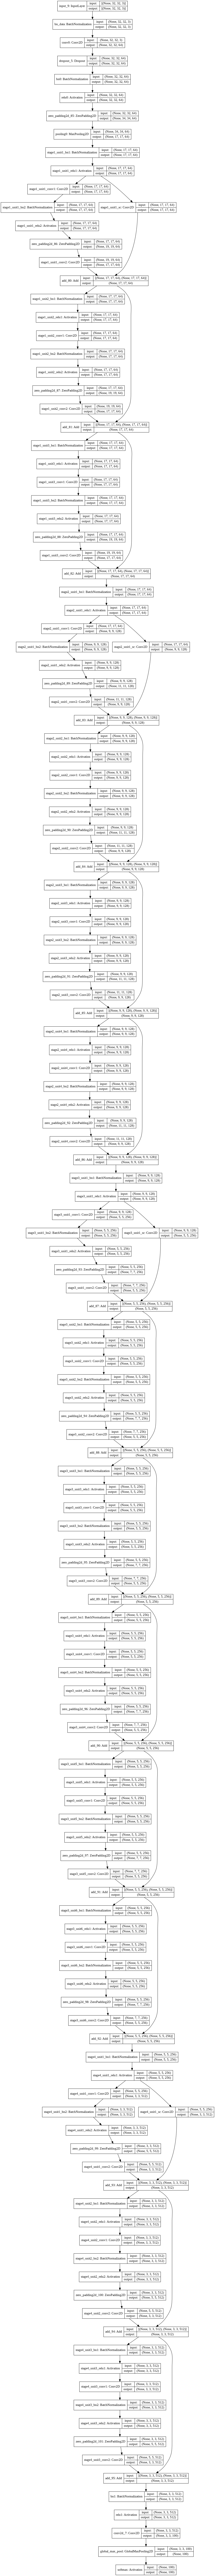

In [0]:
## Displaying Baseline resnet34 network with custom added classification layer
tf.keras.utils.plot_model(resnet_34_cifar_100, to_file='resnet34_cifar100.png', show_layer_names=True, show_shapes=True)

In [0]:
### Lets try to create a new model with reduced network capacity
input_shape = (32,32,3)
img_input = tf.keras.layers.Input(shape=input_shape)

# resnet_34_cifar_100_x = resnet_34_cifar_100.get_layer('stage4_unit3_bn1').output
# resnet_34_cifar_100_x = resnet_34_cifar_100.get_layer('add_14').output  ## result accuracy: 0.6348 - val_loss: 9.4807 - val_accuracy: 0.4901

resnet_34_cifar_100_x = resnet_34_cifar_100.get_layer('add_94').output  ## result accuracy: 0.6348 - val_loss: 9.4807 - val_accuracy: 0.4901

resnet_34_cifar_100_x = tf.keras.layers.Conv2D(100, (1, 1))(resnet_34_cifar_100_x)

# resnet_34_cifar_100_x = tf.keras.layers.Conv2D(100, (3, 3))(resnet_34_cifar_100_x)

resnet_34_cifar_100_x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(resnet_34_cifar_100_x)
# resnet_34_cifar_100_x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(resnet_34_cifar_100_x)
# resnet_34_cifar_100_x = tf.keras.layers.Dense(100, name='global_dense')(resnet_34_cifar_100_x)

predictions = tf.keras.layers.Activation('softmax', name='softmax')(resnet_34_cifar_100_x)

fresnet_34_cifar_100_fntn_model = tf.keras.Model(inputs=resnet_34_cifar_100.input, outputs=predictions)
fresnet_34_cifar_100_fntn_model.summary()
# layers['stage4_unit2_relu1'].output

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           input_9[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 64)   9408        bn_data[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 32, 32, 64)   0           conv0[0][0]                      
___________________________________________________________________________________________

In [0]:
# from tf.keras.callbacks import LearningRateScheduler
schedule = learning_rate_scheduler.StepDecay(initAlpha=1e-1, factor=0.25, dropEvery=2)
# schedule =learning_rate_scheduler.PolynomialDecay(maxEpochs=2, initAlpha=1e-1, power=5) 
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(schedule)

In [0]:
# opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
# fresnet_34_cifar_100_fntn_model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [0]:
checkpoint_path = "eva_assignment_20_further.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
# ModelCheckpoint(filepathx, monitor='val_acc', verbose=1, save_best_only=True)]
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
for layer in fresnet_34_cifar_100_fntn_model.layers:
  print("Layer Name:" ,layer.name, "Trainable:",layer.trainable)

Layer Name: input_9 Trainable: False
Layer Name: bn_data Trainable: False
Layer Name: conv0 Trainable: False
Layer Name: dropout_5 Trainable: False
Layer Name: bn0 Trainable: False
Layer Name: relu0 Trainable: False
Layer Name: zero_padding2d_85 Trainable: False
Layer Name: pooling0 Trainable: False
Layer Name: stage1_unit1_bn1 Trainable: False
Layer Name: stage1_unit1_relu1 Trainable: False
Layer Name: stage1_unit1_conv1 Trainable: False
Layer Name: stage1_unit1_bn2 Trainable: False
Layer Name: stage1_unit1_relu2 Trainable: False
Layer Name: zero_padding2d_86 Trainable: False
Layer Name: stage1_unit1_conv2 Trainable: False
Layer Name: stage1_unit1_sc Trainable: False
Layer Name: add_80 Trainable: False
Layer Name: stage1_unit2_bn1 Trainable: False
Layer Name: stage1_unit2_relu1 Trainable: False
Layer Name: stage1_unit2_conv1 Trainable: False
Layer Name: stage1_unit2_bn2 Trainable: False
Layer Name: stage1_unit2_relu2 Trainable: False
Layer Name: zero_padding2d_87 Trainable: False
Laye

In [0]:
for layer in fresnet_34_cifar_100_fntn_model.layers:
  
  # string[0:5]
  print("Layer Name:" ,layer.name, "Trainable:",layer.trainable)
  if (layer.name[0:6] == 'stage4'):
    print("Updated Trainable Flag to Yes for Layer:",layer.name)
    layer.trainable = True
  # if (layer.name[0:6] == 'stage3'):
  #   print("Updated Trainable Flag to Yes for Layer:",layer.name)
  #   layer.trainable = True

Layer Name: input_9 Trainable: False
Layer Name: bn_data Trainable: False
Layer Name: conv0 Trainable: False
Layer Name: dropout_5 Trainable: False
Layer Name: bn0 Trainable: False
Layer Name: relu0 Trainable: False
Layer Name: zero_padding2d_85 Trainable: False
Layer Name: pooling0 Trainable: False
Layer Name: stage1_unit1_bn1 Trainable: False
Layer Name: stage1_unit1_relu1 Trainable: False
Layer Name: stage1_unit1_conv1 Trainable: False
Layer Name: stage1_unit1_bn2 Trainable: False
Layer Name: stage1_unit1_relu2 Trainable: False
Layer Name: zero_padding2d_86 Trainable: False
Layer Name: stage1_unit1_conv2 Trainable: False
Layer Name: stage1_unit1_sc Trainable: False
Layer Name: add_80 Trainable: False
Layer Name: stage1_unit2_bn1 Trainable: False
Layer Name: stage1_unit2_relu1 Trainable: False
Layer Name: stage1_unit2_conv1 Trainable: False
Layer Name: stage1_unit2_bn2 Trainable: False
Layer Name: stage1_unit2_relu2 Trainable: False
Layer Name: zero_padding2d_87 Trainable: False
Laye

In [0]:
for layer in fresnet_34_cifar_100_fntn_model.layers:
  print("Layer Name:" ,layer.name, "Trainable:",layer.trainable)

Layer Name: input_9 Trainable: False
Layer Name: bn_data Trainable: False
Layer Name: conv0 Trainable: False
Layer Name: dropout_5 Trainable: False
Layer Name: bn0 Trainable: False
Layer Name: relu0 Trainable: False
Layer Name: zero_padding2d_85 Trainable: False
Layer Name: pooling0 Trainable: False
Layer Name: stage1_unit1_bn1 Trainable: False
Layer Name: stage1_unit1_relu1 Trainable: False
Layer Name: stage1_unit1_conv1 Trainable: False
Layer Name: stage1_unit1_bn2 Trainable: False
Layer Name: stage1_unit1_relu2 Trainable: False
Layer Name: zero_padding2d_86 Trainable: False
Layer Name: stage1_unit1_conv2 Trainable: False
Layer Name: stage1_unit1_sc Trainable: False
Layer Name: add_80 Trainable: False
Layer Name: stage1_unit2_bn1 Trainable: False
Layer Name: stage1_unit2_relu1 Trainable: False
Layer Name: stage1_unit2_conv1 Trainable: False
Layer Name: stage1_unit2_bn2 Trainable: False
Layer Name: stage1_unit2_relu2 Trainable: False
Layer Name: zero_padding2d_87 Trainable: False
Laye

In [0]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
fresnet_34_cifar_100_fntn_model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
epochs =7
fresnet_34_cifar_100_fntn_model.fit(train_dataset,
          epochs=epochs,
          verbose=1,
          # epochs=7,
          # initial_epoch=7,
          validation_data=val_dataset,
          shuffle=False,
          validation_freq=1,
          callbacks=[tensorboard_callback, lr_schedule_callback,cp_callback])
# https://github.com/amitkayal/class-balanced-loss/tree/master/src

Epoch 1/7
49/50 [============================>.] - ETA: 1s - loss: 15.4568 - accuracy: 0.1434
Epoch 00001: val_accuracy improved from -inf to 0.24440, saving model to eva_assignment_20_further.hdf5
50/50 [==============================] - 81s 2s/step - loss: 15.4002 - accuracy: 0.1467 - val_loss: 12.8917 - val_accuracy: 0.2444
Epoch 2/7
49/50 [============================>.] - ETA: 1s - loss: 11.7641 - accuracy: 0.3495
Epoch 00002: val_accuracy improved from 0.24440 to 0.30740, saving model to eva_assignment_20_further.hdf5
50/50 [==============================] - 73s 1s/step - loss: 11.7525 - accuracy: 0.3505 - val_loss: 11.6458 - val_accuracy: 0.3074
Epoch 3/7
49/50 [============================>.] - ETA: 1s - loss: 10.9885 - accuracy: 0.4059
Epoch 00003: val_accuracy improved from 0.30740 to 0.35670, saving model to eva_assignment_20_further.hdf5
50/50 [==============================] - 73s 1s/step - loss: 10.9813 - accuracy: 0.4072 - val_loss: 11.1123 - val_accuracy: 0.3567
Epoch 4

In [0]:
# epochs =7
fresnet_34_cifar_100_fntn_model.fit(train_dataset,
          epochs=10,
          verbose=1,
          # epochs=7,
          initial_epoch=7,
          validation_data=val_dataset,
          shuffle=False,
          validation_freq=1,
          callbacks=[tensorboard_callback, lr_schedule_callback,cp_callback])

Epoch 8/10
49/50 [============================>.] - ETA: 1s - loss: 10.2607 - accuracy: 0.4755
Epoch 00008: val_accuracy did not improve from 0.41630
50/50 [==============================] - 74s 1s/step - loss: 10.2588 - accuracy: 0.4757 - val_loss: 10.5211 - val_accuracy: 0.4161
Epoch 9/10
49/50 [============================>.] - ETA: 1s - loss: 10.2551 - accuracy: 0.4732
Epoch 00009: val_accuracy improved from 0.41630 to 0.41770, saving model to eva_assignment_20_further.hdf5
50/50 [==============================] - 74s 1s/step - loss: 10.2528 - accuracy: 0.4736 - val_loss: 10.5073 - val_accuracy: 0.4177
Epoch 10/10
49/50 [============================>.] - ETA: 1s - loss: 10.2465 - accuracy: 0.4749
Epoch 00010: val_accuracy did not improve from 0.41770
50/50 [==============================] - 73s 1s/step - loss: 10.2450 - accuracy: 0.4750 - val_loss: 10.5019 - val_accuracy: 0.4174


In [0]:
fresnet_34_cifar_100_fntn_model.load_weights('eva_assignment_20_further.hdf5')
# for layer in resnet_34_cifar_100.layers:
  
#   # string[0:5]
#   print("Layer Name:" ,layer.name, "Trainable:",layer.trainable)
#   if (layer.name[0:6] == 'stage3'):
#     print("Updated Trainable Flag to Yes for Layer:",layer.name)
#     layer.trainable = True
#   # if (layer.name[0:6] == 'stage3'):
#   #   print("Updated Trainable Flag to Yes for Layer:",layer.name)

#   #   layer.trainable = True

In [0]:
resnet_34_cifar_100.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           input_7[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 64)   9408        bn_data[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 32, 32, 64)   0           conv0[0][0]                      
___________________________________________________________________________________________

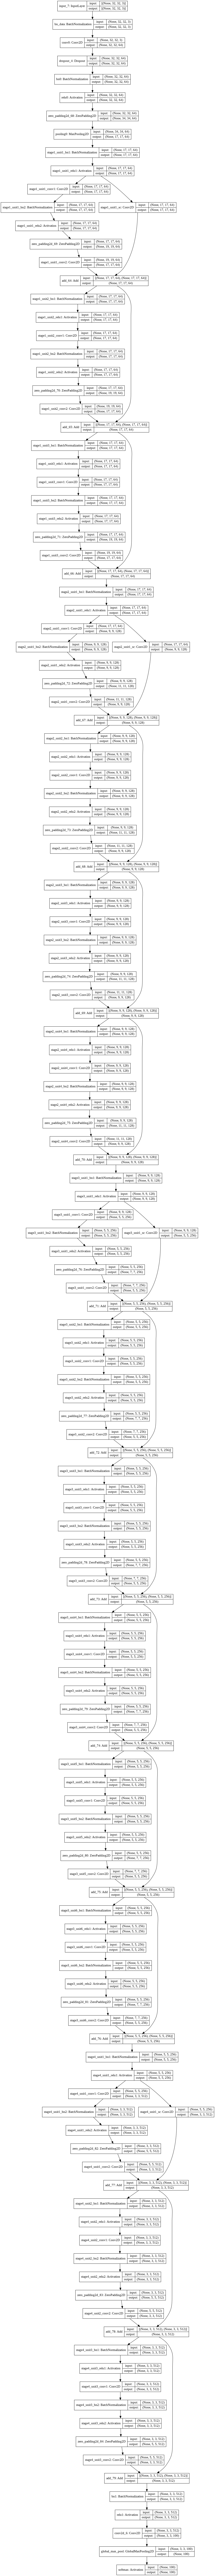

In [0]:
## Displaying Baseline resnet34 network with custom added classification layer
tf.keras.utils.plot_model(resnet_34_cifar_100, to_file='resnet34_cifar110.png', show_layer_names=True, show_shapes=True)

### Experiment - 2 (Take part of model and retrain new ones with more changes)


** Approach did not work and accuracy got stuck with 10%**

In [0]:
### Lets try to create a new model with reduced network capacity
input_shape = (32,32,3)
img_input = tf.keras.layers.Input(shape=input_shape)
no_scale_bn_params = get_bn_params(scale=False)
bn_params = get_bn_params()
conv_params_same = get_conv_params_same()

In [0]:
def build_resnet_2(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_shape = (32,32,3),
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    # input_shape = _obtain_input_shape(input_shape,
    #                                   default_size=224,
    #                                   min_size=101,
    #                                   data_format='channels_last',
    #                                   require_flatten=include_top)

    # if input_tensor is None:
    #     img_input = Input(shape=input_shape, name='data')
    # else:
    #     if not K.is_keras_tensor(input_tensor):
    #         img_input = Input(tensor=input_tensor, shape=input_shape)
    #     else:
    #         img_input = input_tensor
    img_input = tf.keras.layers.Input(shape=input_shape) 
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    conv_params_same =get_conv_params_same()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = tf.keras.layers.BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    # x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(x)
    x = tf.keras.layers.Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    # x = tf.keras.layers.Conv2D(init_filters, (7, 7), kernel_regularizer=tf.keras.regularizers.l2(0.005),strides=(1, 1), name='conv0', **conv_params_same)(x)

    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.BatchNormalization(name='bn0', **bn_params)(x)
    x = tf.keras.layers.Activation('relu', name='relu0')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    # x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    x = tf.keras.layers.MaxPooling2D(padding='valid', name='pooling0')(x)

    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = tf.keras.layers.BatchNormalization(name='bn1', **bn_params)(x)
    x = tf.keras.layers.Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D(name='pool1')(x)
        x = tf.keras.layers.Dense(classes, name='fc1')(x)
        x = tf.keras.layers.Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    # if input_tensor is not None:
    #     inputs = get_source_inputs(input_tensor)
    # else:
    #     inputs = img_input
        
    # Create model.
    model = tf.keras.Model(img_input, x)

    return model

In [0]:
def ResNet34(input_shape, weights=None, classes=100, include_top=True):
    model = build_resnet_2(input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    # model.name = 'resnet34'

    if weights:
        load_model_weights(weights_collection, model, weights, classes=classes, include_top=include_top)
    return model

In [0]:
def build_finetune_model_x(input_shape=(224,224,3), num_classes=100, include_top=False,pooling='max'):

  backbone = ResNet34(input_shape=input_shape, weights='imagenet', 
                      classes=num_classes,include_top=include_top)
  
  for layer in backbone.layers:
    layer.trainable = False
  
  x = backbone.output
  # x = tf.keras.layers.Dropout(0.2)(x)
  if pooling == 'avg':
    x = tf.keras.layers.Conv2D(100, (1, 1))(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
  elif pooling == 'max':
    x = tf.keras.layers.Conv2D(100, (1, 1))(x)
    x = tf.keras.layers.GlobalMaxPooling2D(name='global_max_pool')(x)

  # predictions = tf.keras.layers.Dense(num_classes, name='fc',
  #                           activation='softmax',kernel_initializer="he_normal")(x)
  predictions = tf.keras.layers.Activation('softmax', name='softmax')(x)
  finetune_model = tf.keras.Model(inputs=backbone.input, outputs=predictions)

  print("My model Name:",finetune_model.name)
  return finetune_model

    # x = base_model.output
    # x = Flatten()(x)
    # for fc in fc_layers:
    #     # New FC layer, random init
    #     x = Dense(fc, activation='relu')(x) 
    #     x = Dropout(dropout)(x)

    # predictions = Dense(num_classes, activation='softmax')(x) 

In [0]:
resnet_34_cifar_100_base = build_finetune_model_x()
resnet_34_cifar_100_base.summary()

My model Name: model_11
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           input_11[0][0]                   
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 109, 109, 64) 9408        bn_data[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 109, 109, 64) 0           conv0[0][0]                      
___________________________________________________________________

In [0]:
# resnet_34_cifar_100_x_2 = resnet_34_cifar_100.get_layer('add_14').output  ## result accuracy: 0.6348 - val_loss: 9.4807 - val_accuracy: 0.4901


In [0]:
fresnet_34_cifar_100_fntn_model_2 = tf.keras.models.Sequential()
fresnet_34_cifar_100_fntn_model_2.add(tf.keras.layers.UpSampling2D((2,2)))
fresnet_34_cifar_100_fntn_model_2.add(tf.keras.layers.UpSampling2D((2,2)))
fresnet_34_cifar_100_fntn_model_2.add(layers.UpSampling2D((2,2)))
fresnet_34_cifar_100_fntn_model_2.add(resnet_34_cifar_100_base)
# fresnet_34_cifar_100_fntn_model_2.add(tf.keras.layers.Conv2D(100, (1, 1),**conv_params_same))
# fresnet_34_cifar_100_fntn_model_2.add(tf.keras.layers.GlobalAveragePooling2D())
# fresnet_34_cifar_100_fntn_model_2.add(tf.keras.layers.Activation('softmax'))
# fresnet_34_cifar_100_fntn_model_2.summary()

In [0]:


# X_2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.005),
#                              strides=(1, 1), name='conv0_2', **conv_params_same)(img_input)

# X_2 = tf.keras.layers.BatchNormalization(name='bn_data_2', **no_scale_bn_params)(X_2)
# X_2 = tf.keras.layers.Activation('relu', name='relu_name_2')(X_2)


# X_2 = tf.keras.layers.Conv2D(64, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.005),
#                              strides=(1, 1), name='conv0_2_2', **conv_params_same)(X_2)
# X_2 = tf.keras.layers.BatchNormalization(name='bn_data_2_2', **no_scale_bn_params)(X_2)
# X_2 = tf.keras.layers.Activation('relu', name='relu_name_2_2')(X_2)


# X_2 = tf.keras.layers.Conv2D(256, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(0.005),
#                              strides=(1, 1), name='conv0_2_3', **conv_params_same)(X_2)
# X_2 = tf.keras.layers.BatchNormalization(name='bn_data_2_3', **no_scale_bn_params)(X_2)
# X_2 = tf.keras.layers.Activation('relu', name='relu_name_2_3')(X_2)
# resnet_34_cifar_100_x_2 = resnet_34_cifar_100.get_layer('add_14').output  ## result accuracy: 0.6348 - val_loss: 9.4807 - val_accuracy: 0.4901
# # tf.keras.
# X_2 = tf.keras.models.(resnet_34_cifar_100_x_2)

# # resnet_34_cifar_100_x = resnet_34_cifar_100.get_layer('stage4_unit3_bn1').output
# # resnet_34_cifar_100_x = resnet_34_cifar_100.get_layer('add_14').output  ## result accuracy: 0.6348 - val_loss: 9.4807 - val_accuracy: 0.4901

# # resnet_34_cifar_100_x_2 = resnet_34_cifar_100.get_layer('add_14').output  ## result accuracy: 0.6348 - val_loss: 9.4807 - val_accuracy: 0.4901


# X_2 = tf.keras.layers.Conv2D(100, (1, 1))(X_2)
# X_2 = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X_2)
# predictions_2 = tf.keras.layers.Activation('softmax', name='softmax')(X_2)

# fresnet_34_cifar_100_fntn_model_2 = tf.keras.Model(inputs=img_input, outputs=predictions_2)
# fresnet_34_cifar_100_fntn_model_2.summary()
# layers['stage4_unit2_relu1'].output

In [0]:
# from tf.keras.callbacks import LearningRateScheduler
schedule = learning_rate_scheduler.StepDecay(initAlpha=1e-1, factor=0.25, dropEvery=2)
# schedule =learning_rate_scheduler.PolynomialDecay(maxEpochs=2, initAlpha=1e-1, power=5) 
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(schedule)

In [0]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
fresnet_34_cifar_100_fntn_model_2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
checkpoint_path = "eva_assignment_20_fintn.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
# ModelCheckpoint(filepathx, monitor='val_acc', verbose=1, save_best_only=True)]
# Create checkpoint callback
cp_callback_x = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

log_dir="logs/profile/" +'fntn2'+ datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback_x = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      update_freq='epoch',
                                                      histogram_freq=1, 
                                                      profile_batch = 3)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = np_utils.to_categorical(y_train, 100)
y_test = np_utils.to_categorical(y_test, 100)

In [0]:
epochs =1
fresnet_34_cifar_100_fntn_model_2.fit(x_train,
                                      y_train,
                                      batch_size=128,
                                      verbose=1,
                                      epochs=epochs,
                                      shuffle=False,
                                      validation_data=(x_test, y_test),
                                      callbacks=[tensorboard_callback_x, lr_schedule_callback,cp_callback_x])


          # epochs=epochs,
          # verbose=1,
          # validation_data=val_dataset,
          # shuffle=False,
          # validation_freq=1,
          # callbacks=[tensorboard_callback_x, lr_schedule_callback,cp_callback_x])

Train on 50000 samples, validate on 10000 samples
49920/50000 [============================>.] - ETA: 0s - loss: 16.8672 - accuracy: 0.0099
Epoch 00001: val_accuracy improved from -inf to 0.01000, saving model to eva_assignment_20_fintn.hdf5
50000/50000 [==============================] - 321s 6ms/sample - loss: 16.8672 - accuracy: 0.0099 - val_loss: 16.8536 - val_accuracy: 0.0100


In [0]:
fresnet_34_cifar_100_fntn_model_2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_19 (UpSampling multiple                  0         
_________________________________________________________________
up_sampling2d_20 (UpSampling multiple                  0         
_________________________________________________________________
up_sampling2d_21 (UpSampling multiple                  0         
_________________________________________________________________
model_11 (Model)             (None, 100)               21353773  
Total params: 21,353,773
Trainable params: 51,300
Non-trainable params: 21,302,473
_________________________________________________________________


## Show misclassified Images

In [0]:
## This function will display confusion matrix based on class with denormalised class label

# show_metrices.show_classification_matrix_image(Y_pred=val_pred,
#                                          test_labels=val_label)

In [0]:
## This function will display confusion matrix based on class
show_metrices.show_classification_matrix(Y_pred=val_pred,
                                         test_labels=val_label)

Confusion matrix:
[[ 3  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  2]
 [ 0  0 36 ...  0  0  0]
 ...
 [ 0  0  1 ... 18  0  1]
 [ 0  0  6 ...  1  0  2]
 [ 0  0  0 ...  0  0 41]]


array([[ 3,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  2],
       [ 0,  0, 36, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ..., 18,  0,  1],
       [ 0,  0,  6, ...,  1,  0,  2],
       [ 0,  0,  0, ...,  0,  0, 41]])

IndexError: ignored

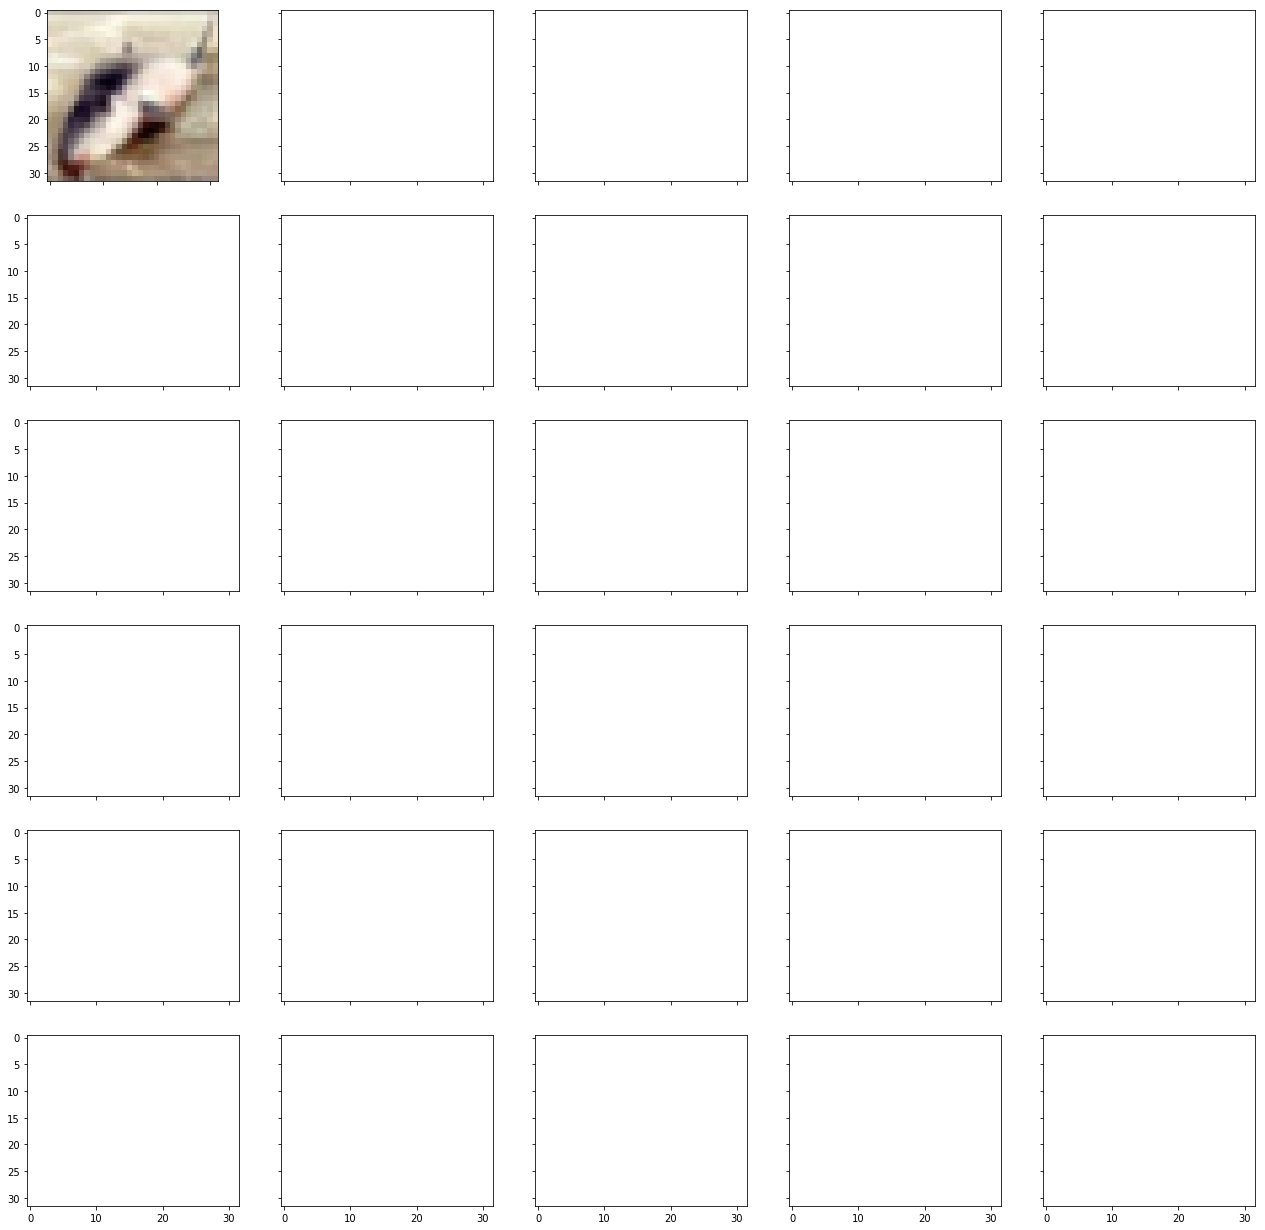

In [0]:
## This function will display misclassified images
show_metrices.show_misclassified_images_cifar10(Y_pred=val_pred,
                                                Y_true_nor=val_label,
                                                X_test= val_image)
# show_misclassified_images(Y_pred=Y_pred,Y_true_nor=test_labels,X_test=test_features)

In [0]:
# Save the trained weights in to .h5 format
# model.save_weights("DNST_model.h5")
# print("Saved model to disk")

In [0]:
# from google.colab import files

# files.download('DNST_model.h5')